In [1]:
from dataclasses import dataclass
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, ndimage
from skimage import transform
from sklearn.datasets import fetch_openml
from tqdm import tqdm

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

/Users/evan/Programming/miniforge3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mnist.data.shape

(70000, 784)

In [41]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X = X[:1000]
y = y[:1000]
X.shape

(1000, 784)

In [42]:
X /= 255.0

In [43]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

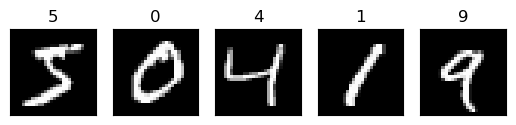

In [10]:
plot_example(X, y)

In [11]:
def qrsvd(X, *, save=False, load=False, file_suffix=None, return_all=False):
    """
    Parameters
    ----------
    X : array-like
        The matrix to decompose.
    save : bool, default=True
        Whether to save the Q, R, U, s, and Vh matrices to disk.
    load : bool, default=True
        Whether to load the Q, R, U, s, and Vh matrices from disk if they exist.
    file_suffix : str, default=""
        The suffix to append to the file names if saving or loading. An underscore
        will be prepended to the suffix if it is given.
    return_all : bool, default=False
        Whether to return all of the matrices or just the singular values.
    """
    file_suffix = "" if file_suffix is None else f"_{file_suffix}"
    # These are separate try/except blocks so that if the QR decomposition succeeds
    # but the SVD fails, we don't have to recompute the QR decomposition.
    try:
        if not load:
            raise OSError
        Q = np.load(f"Q{file_suffix}.npy")
        R = np.load(f"R{file_suffix}.npy")
    except OSError:
        Q, R = linalg.qr(X)
        if save:
            np.save(f"Q{file_suffix}.npy", Q)
            np.save(f"R{file_suffix}.npy", R)

    try:
        if not load:
            raise OSError
        U = np.load(f"U{file_suffix}.npy")
        s = np.load(f"s{file_suffix}.npy")
        Vh = np.load(f"Vh{file_suffix}.npy")
    except OSError:
        U, s, Vh = linalg.svd(R)
        if save:
            np.save(f"U{file_suffix}.npy", U)
            np.save(f"s{file_suffix}.npy", s)
            np.save(f"Vh{file_suffix}.npy", Vh)

    return (Q, U, s, Vh) if return_all else s

In [12]:
s = qrsvd(X)

In [65]:
figsize = (13.33, 7.5)
dpi = 96
tick_labelsize = 16
linewidths = 4
label_fontsize = 20
title_fontsize = 24

In [79]:
def plot_singular_values(*s_list, labels=None, title:str=None, save=False):
    """Plot the singular values of the given matrices."""
    plt.figure(figsize=figsize, dpi=dpi)
    plt.tick_params(labelsize=tick_labelsize)
    plt.xlabel("Index", fontsize=label_fontsize)
    plt.ylabel("Log of Singular Value", fontsize=label_fontsize)
    if title is not None:
        plt.title(title, fontsize=title_fontsize)
    for s in s_list:
        plt.scatter(np.arange(len(s)), np.log(s), linewidths=linewidths)
    if labels is not None:
        plt.legend(labels, fontsize=label_fontsize)
    plt.tight_layout()
    if save:
        plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

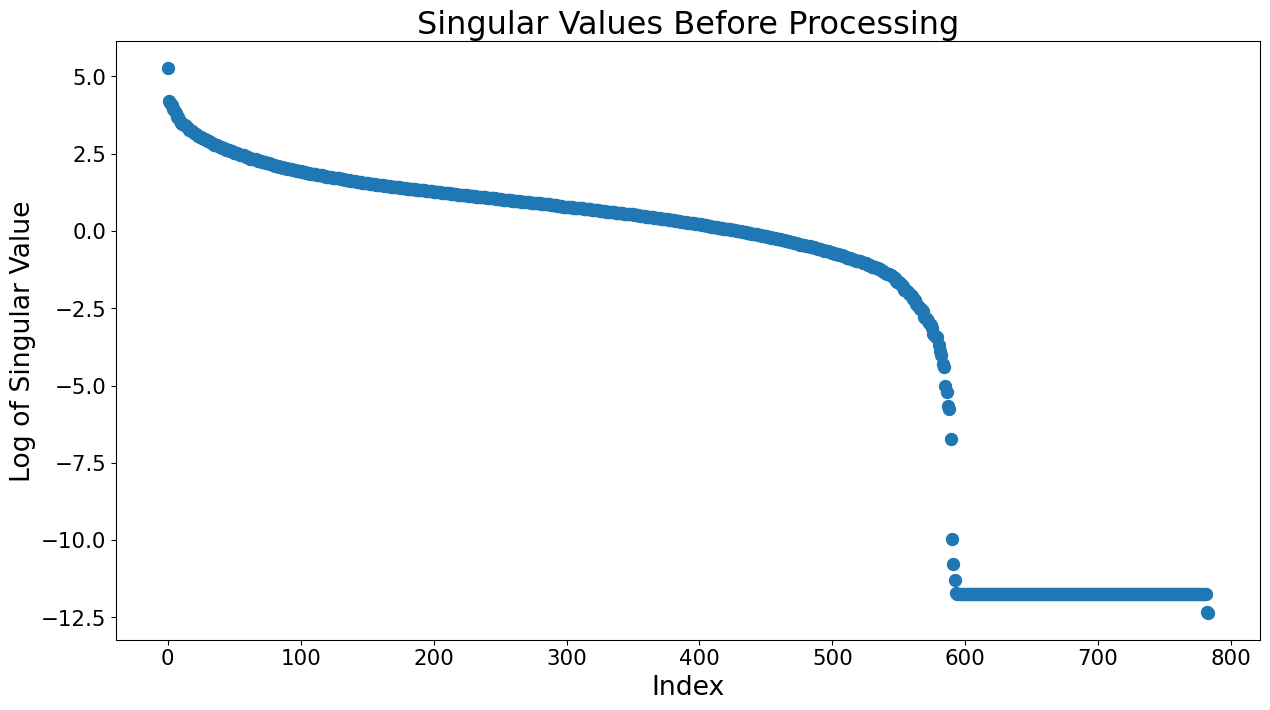

In [80]:
plot_singular_values(s, title="Singular Values Before Processing")

## Translation
- Find center of the bounding box
- Translate the bounding box center to the image center
- Add translation vector to dimensions
- SVD 

In [29]:
# modified code, original source: https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def find_bbox(img):
    img = np.where(img>0.3, img, 0)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax+1, cmin, cmax+1

In [47]:
def recenter_imgs(imgs):
    imgs_recentered = np.zeros_like(imgs)

    for i, img in tqdm(enumerate(imgs)):
        img = img.reshape(28,28)
        rmin, rmax, cmin, cmax = find_bbox(img)
        # bbox_center = ((rmin + rmax)//2,  (cmin + cmax)//2)
        
        bbox_img = img[rmin:rmax, cmin:cmax]

        padr1 = padr2 = (28-(rmax-rmin))//2
        padc1 = padc2 = (28-(cmax-cmin))//2

        if (rmax+rmin)%2 == 1:
            padr2 += 1
        if (cmax+cmin)%2 == 1:
            padc2 += 1

        recentered_img = np.pad(bbox_img, ((padr1, padr2), (padc1, padc2)))
        imgs_recentered[i] = recentered_img.flatten()

    return imgs_recentered

1000it [00:00, 30379.42it/s]

7 27 8 20
(17, 14)


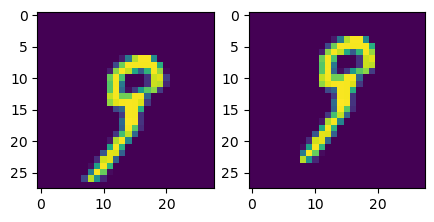

In [46]:
X_recentered = recenter_imgs(X)

fig, axes = plt.subplots(1,2, figsize=(5,2.5))
axes[0].imshow(X[19].reshape(28,28))
axes[1].imshow(X_recentered[19].reshape(28,28))

rmin, rmax, cmin, cmax = find_bbox(X[19].reshape(28,28))
bbox_center = ((rmin + rmax)//2,  (cmin + cmax)//2)
print(rmin, rmax, cmin, cmax)
print(bbox_center)

In [48]:
s_rec = qrsvd(X_recentered)

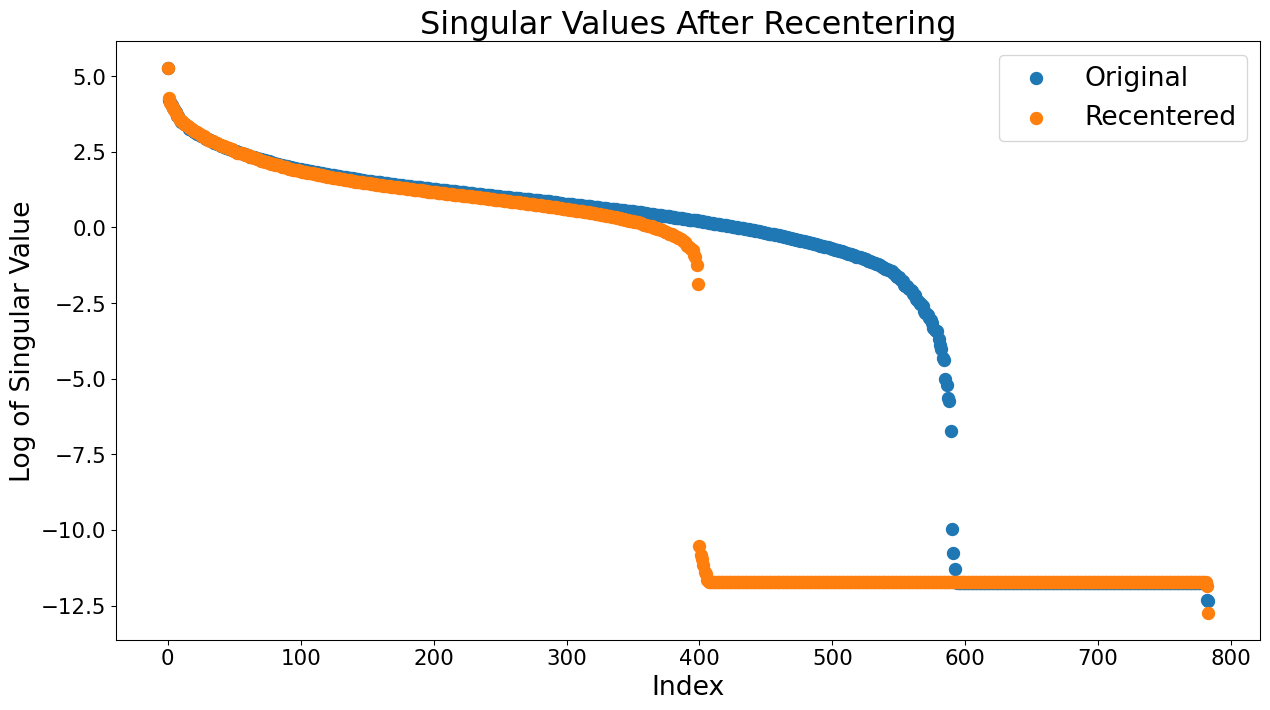

In [81]:
plot_singular_values(
    s, s_rec,
    labels=["Original", "Recentered"],
    title="Singular Values After Recentering",
    save=True,
)

## Split by class

In [ ]:
digits = {}
si_list = []

for i in range(10):
    digits[i] = X[y==i]

In [ ]:
for i in range(10):
    print(digits[i].shape)
    Qi, Ri = linalg.qr(digits[i])
    Ui, si, Vhi = linalg.svd(Ri)
    si_list.append(si)

In [ ]:
fig, ax = plt.subplots(10, 1, figsize=(10,30))

for i in range(10):
    ax[i].scatter(np.arange(0,784), np.log(si_list[i]))
    ax[i].set_title(f'Singular Values for Class [i]')

## Nonlinear transformation

In [82]:
X2 = (X>0.5).astype('float32')
s2 = qrsvd(X2)

In [84]:
def plot_digit(img):
    if img.ndim == 1:
        img = img.reshape(28, 28)
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout();

In [ ]:
X3 = (np.square(X)>0.75).astype('float32')
s3 = qrsvd(X3)

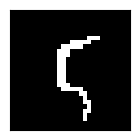

In [85]:
plot_digit(X3[100])

In [86]:
X4 = (np.sqrt(X)>0.99).astype('float32')
s4 = qrsvd(X4)

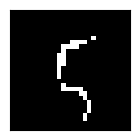

In [87]:
plot_digit(X4[100])

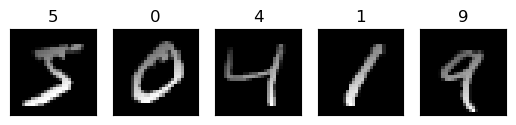

In [88]:
def weight_by_position(X):
    X_weighted = np.zeros_like(X)
    for i, img in enumerate(X):
        img = img.reshape(28,28).copy()
        for r in range(28):
            for c in range(28):
                img[r,c] *= (r/56 + c/56/2)
        X_weighted[i] = img.flatten()
    return X_weighted

X_weighted = weight_by_position(X)
plot_example(X_weighted, y)
X5 = (X_weighted>0.25).astype('float32')
s5 = qrsvd(X5)

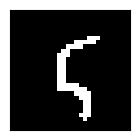

In [89]:
plot_digit(X5[100])

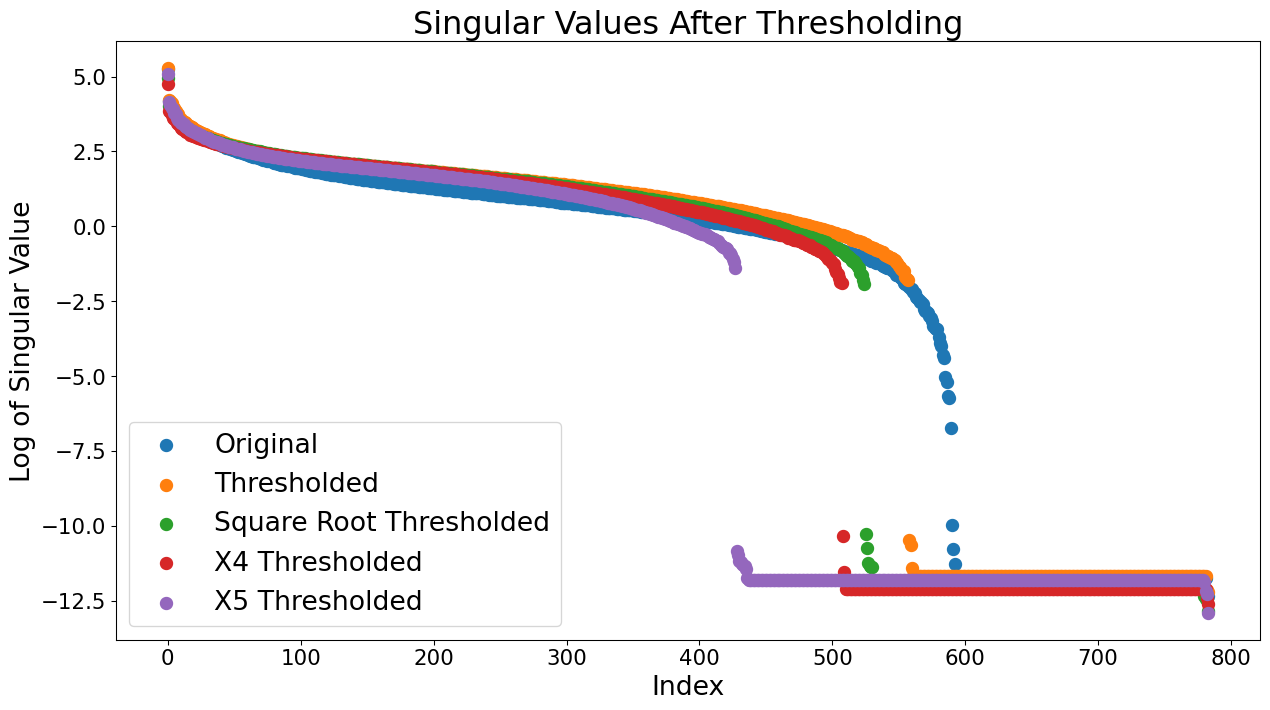

In [90]:
plot_singular_values(
    s, s2, s3, s4, s5,
    labels=["Original", "Thresholded", "Square Root Thresholded", "X4 Thresholded", "X5 Thresholded"],
    title="Singular Values After Thresholding",
    # save=True,
)

## Rotation

### Using linear regression

In [91]:
@dataclass
class Line:
    x1: float
    y1: float
    x2: float
    y2: float

    def __post_init__(self):
        self.is_vertical = self.x1 == self.x2
        self._rise = self.y2 - self.y1
        self._run = self.x2 - self.x1
        if not self.is_vertical:
            self._slope = self._rise / self._run
            self._intercept = self.y1 - self._slope * self.x1
        else:
            self._slope = math.inf
            self._intercept = math.nan

    @classmethod
    def from_points(cls, point1, point2):
        cls(*point1, *point2)

    @classmethod
    def from_point_slope(cls, point, slope):
        return cls(*point, 0, point[1] - slope * point[0])

    @classmethod
    def from_slope_intercept(cls, slope, intercept):
        return cls(0, intercept, 1, intercept + slope)

    @classmethod
    def from_angle(cls, angle, point=(0, 0), *, unit="degrees"):
        if unit == "degrees" or unit == "deg":
            angle = math.radians(angle)
        slope = math.tan(angle)
        return cls.from_slope_intercept(slope, point[1] - slope * point[0])

    def __call__(self, x):
        """Returns the y value of the line at x."""
        if self.is_vertical:
            return math.nan
        return self._slope * x + self._intercept

    def for_graph(self, x_min=None, x_max=None, y_min=None, y_max=None):
        """Returns the x and y values for the line between x_min and x_max."""
        if self.is_vertical:
            return (self.x1, self.x1), (y_min, y_max)
        x_min = self.x1 if x_min is None else x_min
        x_max = self.x2 if x_max is None else x_max
        return (x_min, x_max), (self(x_min), self(x_max))

    @property
    def slope(self):
        return self._slope

    @property
    def intercept(self):
        return self._intercept # y-intercept

    def __convert_angle(self, angle, unit):
        if unit == "radians" or unit == "rad":
            return angle
        elif unit == "degrees" or unit == "deg":
            return math.degrees(angle)
        else:
            raise ValueError("Invalid unit.")

    def angle(self, unit="degrees"):
        """Returns the angle of inclination of the line."""
        return self.__convert_angle(math.atan2(self._rise, self._run), unit)

    def angle_between(self, other, unit="degrees"):
        """Returns the angle from this line to another line."""
        angle = math.pi - abs(other.angle() - self.angle())
        return self.__convert_angle(angle, unit)

In [96]:
# https://stackoverflow.com/a/52812908

def feature(x, order):
    """Generate polynomial feature of the form
    [1, x, x^2, ..., x^order] where x is the column of x-coordinates
    and 1 is the column of ones for the intercept.
    """
    x = x.reshape(-1, 1)
    return np.power(x, np.arange(order + 1).reshape(1, -1))


def regress(img: np.ndarray, *, order, alpha=0.01, threshold=0.25, weighted=True):
    mask = img > threshold
    indices = np.argwhere(mask) # Get indices of pixels corresponding to marked region

    X = indices[:, 1].reshape(-1, 1) # Column indices
    X = feature(X, order) # Polynomial features
    Y = indices[:, 0] # Row indices to predict. Note origin is at top left corner

    X_T = X.T
    if weighted:
        W = np.diag(img[mask] / float(img.max())) # weight matrix
        X_T = X_T.dot(W)

    I = np.eye(X.shape[1])
    B = np.linalg.pinv(X_T.dot(X) + alpha * I).dot(X_T).dot(Y)
    return B

def linreg(img: np.ndarray, *, alpha=0.01, threshold=0.25, weighted=True):
    B = regress(img, order=1, alpha=alpha, threshold=threshold, weighted=weighted)
    x = np.asarray([0, img.shape[1] - 1])
    y = feature(x, 1).dot(B)
    return Line(x[0], y[0], x[1], y[1])

def plot_reg(img: np.ndarray, *, order=1, alpha=0.01, threshold=0.25, n_samples=2, ax=None):
    B_unw = regress(img, order=order, alpha=alpha, threshold=threshold, weighted=False)
    B_w = regress(img, order=order, alpha=alpha, threshold=threshold, weighted=True)
    x = np.linspace(0, img.shape[1] - 1, n_samples)
    y_unw = feature(x, order).dot(B_unw)
    y_w = feature(x, order).dot(B_w)

    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_ylim(27, 0)
    ax.plot([0, 27], [14, 14])
    ax.plot(x, y_unw, label='Unweighted')
    ax.plot(x, y_w, label='Weighted')
    ax.legend(fontsize="xx-small")

In [93]:
def linreg2(img: np.ndarray, *, threshold=0, weighted=True):
    Y, X = np.nonzero(img > threshold)
    A = np.vstack([X, np.ones(len(X))]).T

    if weighted:
        weights = img[X, Y] / float(img.max())
        W = np.diag(weights)
        m, c = np.linalg.lstsq(A.T.dot(W).dot(A), A.T.dot(W).dot(Y), rcond=None)[0]
    else:
        m, c = np.linalg.lstsq(A, Y, rcond=None)[0]

    return Line(0, c, 27, m * 27 + c)

In [94]:
def test_linreg_rotation(img, *, linreg=linreg, order=1, **kwargs):
    img = img.reshape(28, 28)
    B = linreg(img, **kwargs)
    print(f"Angle from x-axis: {B.angle('deg'):.2f} degrees")

    img_rot = ndimage.rotate(img, angle=-B.angle('deg'), reshape=False, order=order)
    img_rot2 = transform.rotate(img, angle=-B.angle("deg"), order=order, preserve_range=True)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
    plt.ylim(0, 27)
    plot_reg(img, ax=axes[0], **kwargs)
    plot_reg(img_rot, ax=axes[1], **kwargs)
    plot_reg(img_rot2, ax=axes[2], **kwargs)

Angle from x-axis: -26.36 degrees


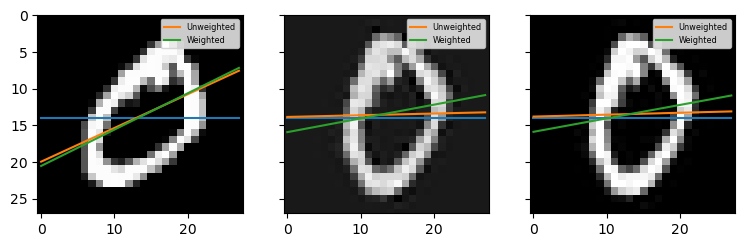

In [97]:
test_linreg_rotation(X[1], threshold=0, order=4)

Angle from x-axis: -18.33 degrees


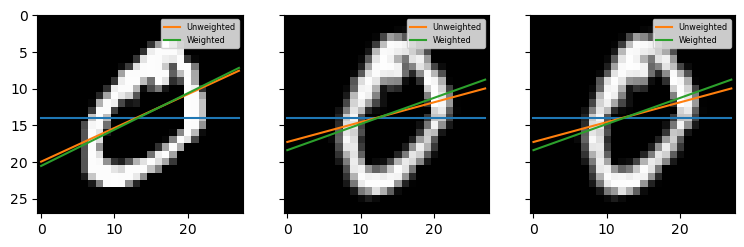

In [98]:
test_linreg_rotation(X[1], threshold=0, linreg=linreg2)

In [99]:
def test_straighten_linreg(imgs, *, order=None, **kwargs):
    # imgs has shape (n, 784)

    # plot singular values of imgs, imgs rotated by angle, and imgs
    # rotated by angle + 90

    imgs = imgs.reshape(-1, 28, 28)
    angles = np.asarray([
        linreg(img, **kwargs, weighted=False).angle("deg") for img in imgs
    ])
    angles_w = np.asarray([
        linreg(img, **kwargs, weighted=True).angle("deg") for img in imgs
    ])
    imgs_rot = np.asarray([
        transform.rotate(img, angle=-angle, order=order) for img, angle in zip(imgs, angles)
    ]).reshape(-1, 784)
    imgs_w_rot = np.asarray([
        transform.rotate(img, angle=-angle, order=order) for img, angle in zip(imgs, angles_w)
    ]).reshape(-1, 784)
    imgs = imgs.reshape(-1, 784)

    # imgs = recenter_imgs(imgs)
    # imgs_rot = recenter_imgs(imgs_rot)
    # imgs_w_rot = recenter_imgs(imgs_w_rot)

    s = qrsvd(imgs, save=False, load=False)
    s_rot = qrsvd(imgs_rot, save=False, load=False)
    s_w_rot = qrsvd(imgs_w_rot, save=False, load=False)

    plot_singular_values(
        s, s_rot, s_w_rot,
        labels=["Original", "Rotated", "Weighted Rotated"],
        title="Singular Values After Straightening with Linear Regression",
        # save=True,
    )

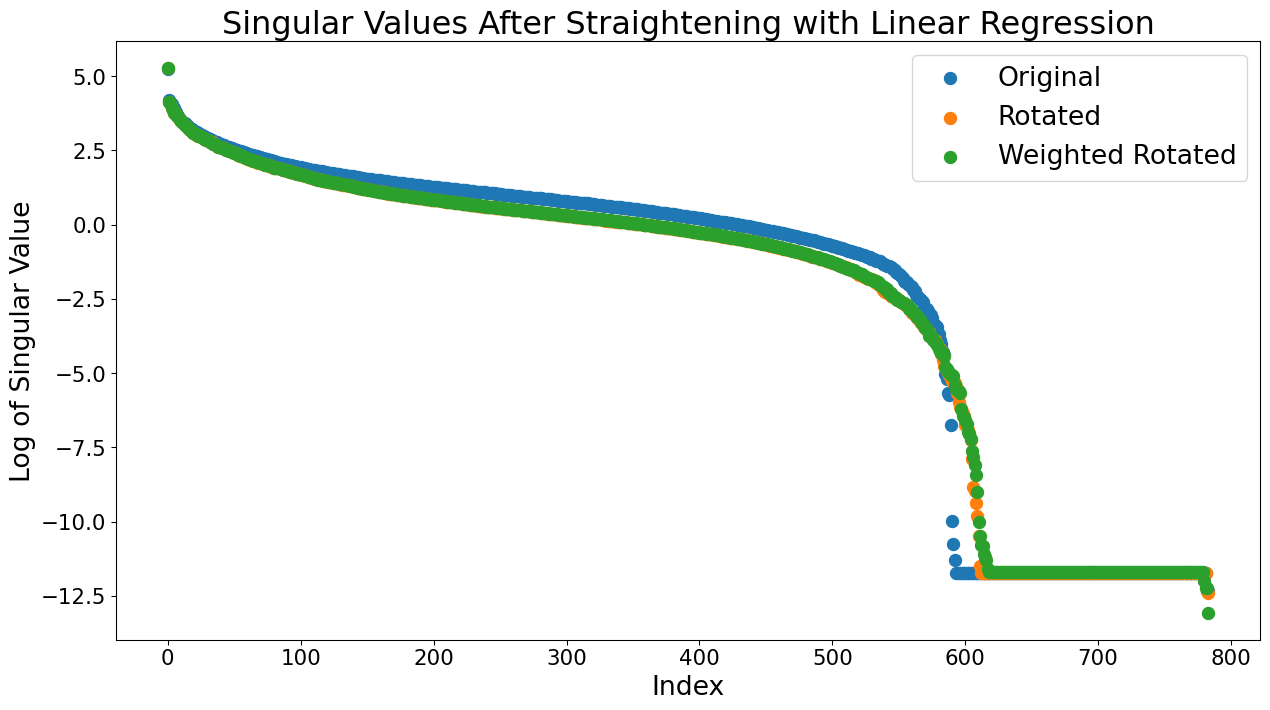

In [100]:
test_straighten_linreg(X[:1000], threshold=0.5, order=1)

### Using Radon transform

In [101]:
def straightening_angle(img: np.ndarray, theta=None):
    if theta is None:
        theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = transform.radon(img, theta=theta)
    _, max_col = np.unravel_index(np.argmax(sinogram), sinogram.shape)
    angle = -theta[max_col]
    return angle

def straighten(img: np.ndarray, resize=False, **kwargs):
    angle = straightening_angle(img, **kwargs)
    return transform.rotate(img, angle, resize=resize)

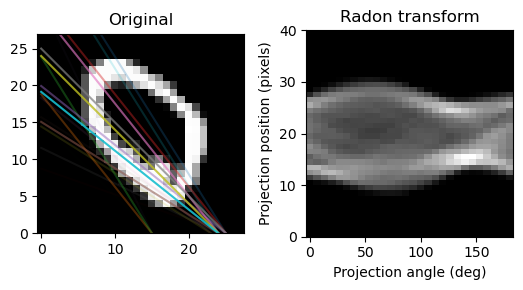

In [105]:
img = X[1].reshape(28, 28)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.333, 3))

ax1.set_title("Original")
ax1.set_ylim([0, 27])
ax1.imshow(img, cmap='gray')

theta = np.linspace(0., 180., max(img.shape), endpoint=False)
sinogram = transform.radon(img, theta=theta, circle=False)
dx, dy = 0.5 * 180.0 / max(img.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap='gray',
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

n = 20
for i, (offset, angle_i) in enumerate(zip(
    *np.unravel_index(np.argsort(sinogram, axis=None)[-n:], sinogram.shape)
)):
    ax1.plot(*Line.from_angle(theta[angle_i], (offset, 0)).for_graph(0, 27), alpha=i**2/n**2)

fig.tight_layout()
plt.show()

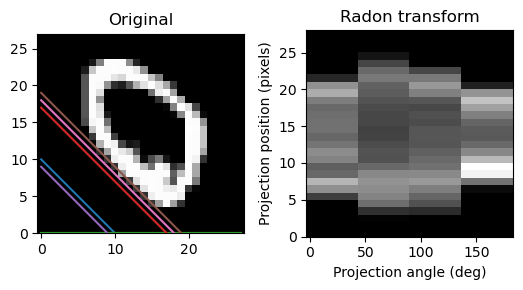

In [ ]:
img = X[1].reshape(28, 28)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.333, 3))

ax1.set_title("Original")
ax1.set_ylim([0, 27])
ax1.imshow(img, cmap='gray')

theta = [0, 45, 90, 135]
sinogram = transform.radon(img, theta=theta)
dx, dy = 0.5 * 180.0 / max(img.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap='gray',
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

n = 7
for i, (offset, angle_i) in enumerate(zip(
    *np.unravel_index(np.argsort(sinogram, axis=None)[-n:], sinogram.shape)
)):
    # ax1.plot(*Line.from_angle(theta[angle_i] + 90, (offset, 0)).for_graph(0, 27))
    ax1.plot(*Line.from_angle(theta[angle_i], (offset, 0)).for_graph(0, 27))

fig.tight_layout()
plt.show()

In [ ]:
np.unravel_index(np.argsort(sinogram, axis=None)[-n:], sinogram.shape)

(array([10,  8, 20, 17,  9, 19, 18]), array([3, 0, 0, 3, 3, 3, 3]))

In [ ]:
Line.from_angle(theta[3] + 90, (offset, 0))

Line(x1=0, y1=-17.999999999999993, x2=1, y2=-16.999999999999993)

In [ ]:
straightening_angle(img)

-138

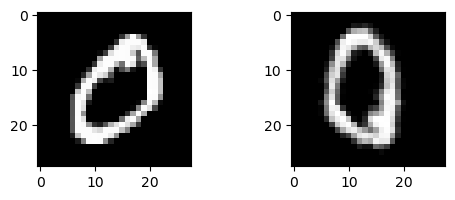

In [ ]:
img = X[1].reshape(28, 28)

fig, axes = plt.subplots(1, 2, figsize=(6, 2))

axes[0].imshow(img, cmap="gray")
axes[1].imshow(straighten(img), cmap="gray")

plt.show()

In [ ]:
def test_straighten(imgs, *, plot_individual=False, **kwargs):
    imgs = imgs.reshape(-1, 28, 28)
    imgs_rot = np.asarray([
        straighten(img, **kwargs) for img in imgs
    ]).reshape(-1, 784)
    imgs_rot_recentered = recenter_imgs(imgs_rot)
    imgs = imgs.reshape(-1, 784)

    s = qrsvd(imgs, save=False, load=False)
    s_rot = qrsvd(imgs_rot, save=False, load=False)
    s_rot_recentered = qrsvd(imgs_rot_recentered, save=False, load=False)

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    titles = ["Original", "Rotated", "Rotated and Recentered"]
    if plot_individual:
        fig, axes = plt.subplots(4, 1, figsize=(10, 12))
        main_ax = axes[2]
        for i, svals in enumerate([s, s_rot]):
            axes[i].scatter(np.arange(svals.shape[0]), np.log(svals), color=colors[i])
            axes[i].set_title(titles[i])
    else:
        fig, main_ax = plt.subplots(1, 1, figsize=(10, 3))
    main_ax.scatter(np.arange(s.shape[0]), np.log(s), label=titles[0])
    main_ax.scatter(np.arange(s_rot.shape[0]), np.log(s_rot), label=titles[1])
    main_ax.scatter(np.arange(s_rot_recentered.shape[0]), np.log(s_rot_recentered), label=titles[2])
    main_ax.legend()
    main_ax.set_title("All Together")

1000it [00:00, 36485.53it/s]


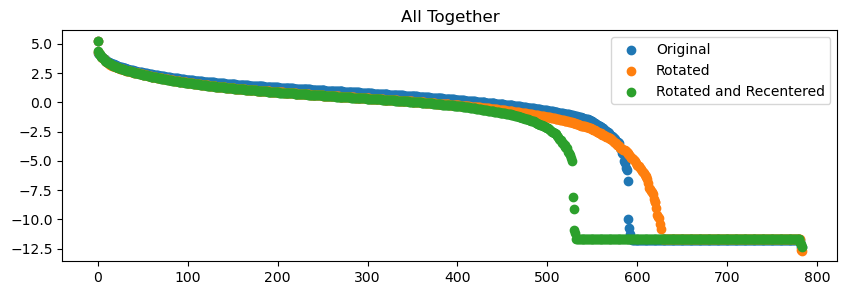

In [ ]:
test_straighten(X[:1000])

1000it [00:00, 18746.58it/s]
1000it [00:00, 22536.21it/s]
/Users/evan/Programming/miniforge3/lib/python3.9/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
1000it [00:00, 38381.61it/s]


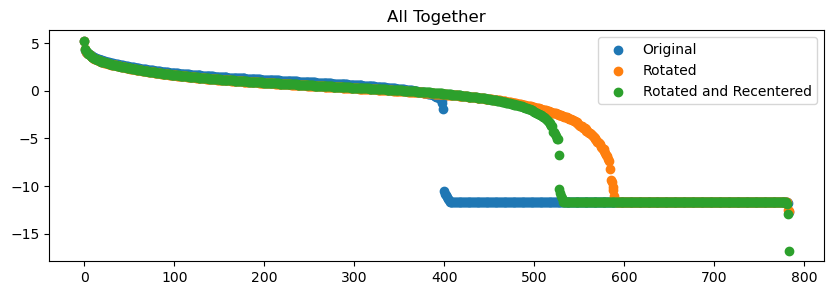

In [ ]:
test_straighten(recenter_imgs(X[:1000]))

In [ ]:
def plot_straighten(imgs, **kwargs):
    n = kwargs.pop("n", min(10, imgs.shape[0]))
    imgs = imgs.reshape(-1, 28, 28)
    angles = np.asarray([straightening_angle(img) for img in imgs])
    imgs_rot = np.asarray([
        straighten(img, angle=angle, **kwargs)
        for img, angle in zip(imgs, angles)
    ])
    # imgs_rot_perp = np.asarray([
    #     straighten(img, angle=angle, **kwargs)
    #     for img, angle in zip(imgs, angles + 90)
    # ])

    fig, axes = plt.subplots(n, 2, figsize=(6, 2 * n))
    for i in range(n):
        axes[i, 0].imshow(imgs[i], cmap="gray")
        axes[i, 1].imshow(imgs_rot[i], cmap="gray")
        # axes[i, 2].imshow(imgs_rot_perp[i], cmap="gray")

/Users/evan/Programming/miniforge3/lib/python3.9/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


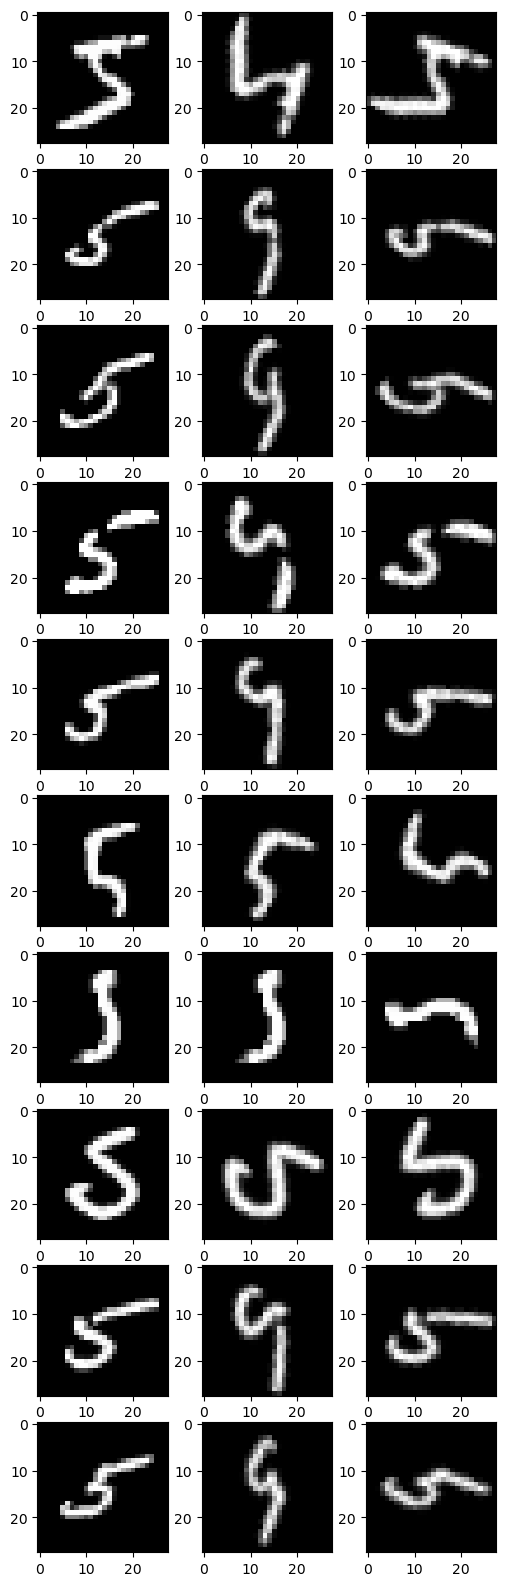

In [ ]:
plot_straighten(digits[5][:10])

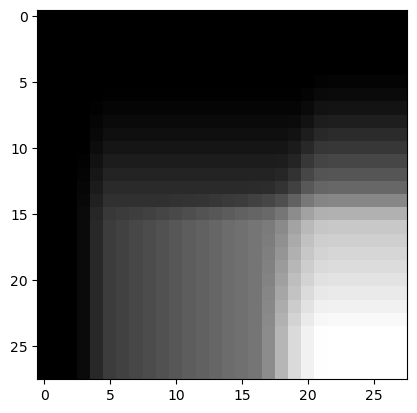

In [ ]:
ii = np.cumsum(np.cumsum(X[2].reshape(28, 28), axis=-1), axis=-2)
plt.imshow(ii, cmap="gray")

In [ ]:
def cumsum(img):
    return np.cumsum(np.cumsum(img, axis=-1), axis=-2)

def diff(img):
    return np.diff(np.diff(img, prepend=0, axis=-1), prepend=0, axis=-2)

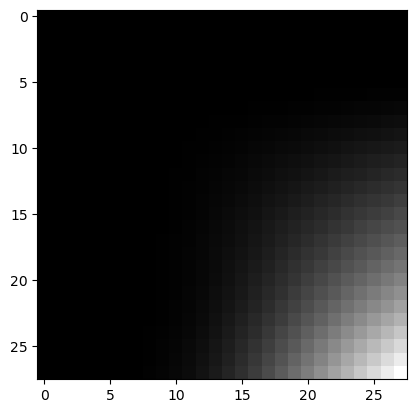

In [ ]:
plt.imshow(((cumsum(cumsum(X[0].reshape(28, 28))))), cmap="gray")

In [ ]:
s = qrsvd(X[2000:3000])

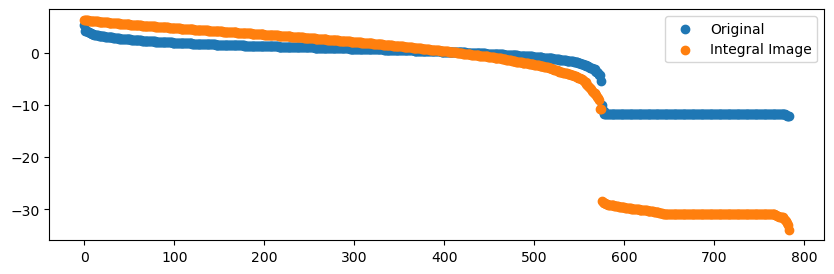

In [ ]:
X_ii = diff(diff(diff(diff(X[2000:3000].reshape(-1, 28, 28)))))
s_ii = qrsvd(X_ii.reshape(-1, 784))
plt.figure(figsize=(10,3))
plt.scatter(np.arange(0,784), np.log(s), label='Original')
plt.scatter(np.arange(0,784), np.log(s_ii), label='Integral Image')
plt.legend()

## k-means grouping

In [38]:
def twodim(vec, dim):
    result = []
    i = 1
    while i * dim <= len(vec):
        result = result + [vec[(i - 1)*dim:i*dim]]
        i = i + 1
    return result
x = [1, 2, 3, 4]
twodim(x, 2)

[[1, 2], [3, 4]]

In [ ]:
def center_of_mass(x):
    result = []
    for elem in x:
        xy = (0, 0)
        for val in elem:
            

In [35]:
x = [1, 2, 3, 4]
x[0:2]

[1, 2]

In [94]:
from scipy import ndimage
import numpy
print(ndimage.center_of_mass(np.array(twodim(X[1], 28)))[0])
print(X.shape)
ComX = []
for elem in X:
    ComX = ComX + [[ndimage.center_of_mass(np.array(twodim(elem, 28)))[0], ndimage.center_of_mass(np.array(twodim(elem, 28)))[1]]]
ComX = np.array(ComX)

13.553304389773276
(10000, 784)


In [95]:
def initialize_random_centroids(K, X):
    """Initializes and returns k random centroids"""
    m, n = np.shape(X)
    # a centroid should be of shape (1, n), so the centroids array will be of shape (K, n)
    centroids = np.empty((K, n))
    for i in range(K):
        # pick a random data point from X as the centroid
        centroids[i] =  X[np.random.choice(range(m))] 
    return centroids

def closest_centroid(x, centroids, K):
    """Finds and returns the index of the closest centroid for a given vector x"""
    distances = np.empty(K)
    for i in range(K):
        distances[i] = euclidean_distance(centroids[i], x)
    return np.argmin(distances) # return the index of the lowest distance

def create_clusters(centroids, K, X):
    """Returns an array of cluster indices for all the data samples"""
    m, _ = np.shape(X)
    cluster_idx = np.empty(m)
    for i in range(m):
        cluster_idx[i] = closest_centroid(X[i], centroids, K)
    return cluster_idx

def compute_means(cluster_idx, K, X):
    """Computes and returns the new centroids of the clusters"""
    _, n = np.shape(X)
    centroids = np.empty((K, n))
    for i in range(K):
        points = X[cluster_idx == i] # gather points for the cluster i
        centroids[i] = np.mean(points, axis=0) # use axis=0 to compute means across points
    return centroids

def run_Kmeans(K, X, max_iterations=500):
    """Runs the K-means algorithm and computes the final clusters"""
    # initialize random centroids
    centroids = initialize_random_centroids(K, X)
    # loop till max_iterations or convergance
    print(f"initial centroids: {centroids}")
    for _ in range(max_iterations):
        # create clusters by assigning the samples to the closet centroids
        clusters = create_clusters(centroids, K, X)
        previous_centroids = centroids                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
        # compute means of the clusters and assign to centroids
        centroids = compute_means(clusters, K, X)
        # if the new_centroids are the same as the old centroids, return clusters
        diff = previous_centroids - centroids
        if not diff.any():
            return clusters
    return clusters

def euclidean_distance(x1, x2):
    """Calculates and returns the euclidean distance between two vectors x1 and x2"""
    return np.sqrt(np.sum(np.power(x1 - x2, 2)))


#its all from https://dev.to/sajal2692/coding-k-means-clustering-using-python-and-numpy-fg1 this guy

In [117]:
testData = [[1, 2], [3, 4], [5, 6]]
#print(ComX)
Xkmeans = run_Kmeans(10, ComX)


initial centroids: [[13.58247053 13.61340273]
 [13.9734699  13.75865938]
 [13.99314119 13.79985407]
 [14.11783666 13.69498894]
 [14.19505869 13.55032754]
 [14.14405567 14.17891519]
 [13.74545371 13.96215644]
 [14.1988453  14.21944869]
 [13.83911048 14.33314508]
 [13.76768366 13.70262039]]


array([1., 6., 1., 3., 1., 2., 5., 5., 3., 8.])

In [120]:
Xkmeans[:20]
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


initial centroids: [[ 8.97320324  9.36434006]
 [ 7.92520229 -0.551253  ]
 [ 6.80596377 -0.25678573]]


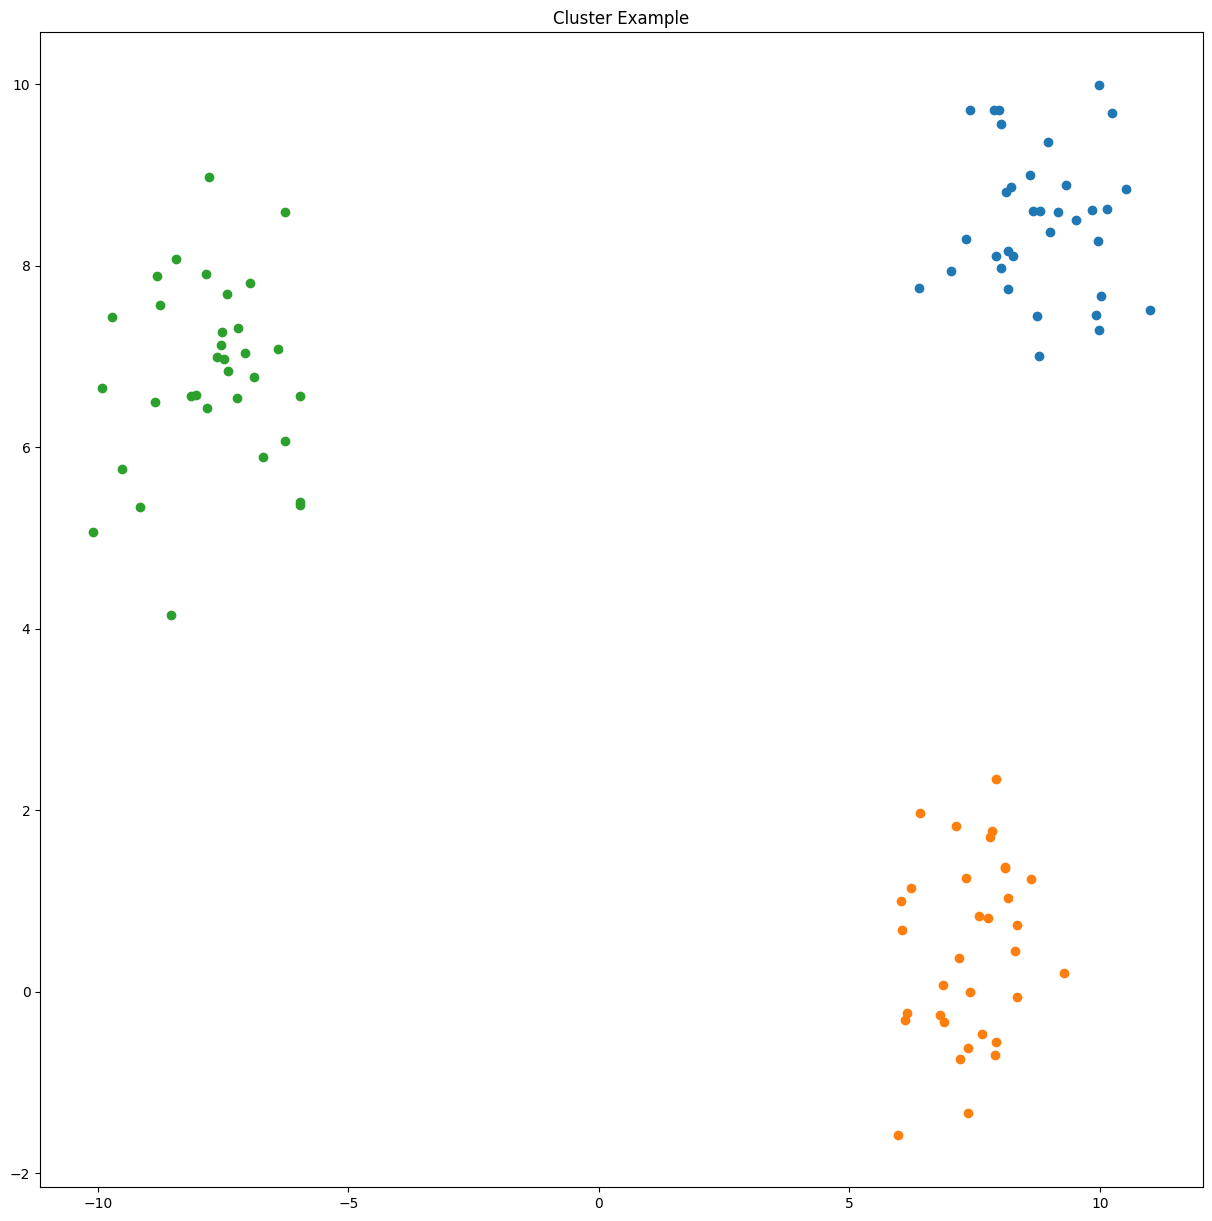

In [162]:
from sklearn import datasets
# creating a dataset for clustering
datX, y = datasets.make_blobs()
y_preds = run_Kmeans(3, datX, 10000)

plt.figure(figsize=(15,15))
plt.title('Cluster Example')
for i in range(3):
    xs = []
    ys = []
    for j in range(len(datX)):
        if y_preds[j] == i:
            
            xs = xs + [datX[j][0]]
            ys = ys + [datX[j][1]]
    plt.scatter(xs, ys)

Text(0.5, 1.0, 'Clusters of Image Vectors Based on Center of Mass')

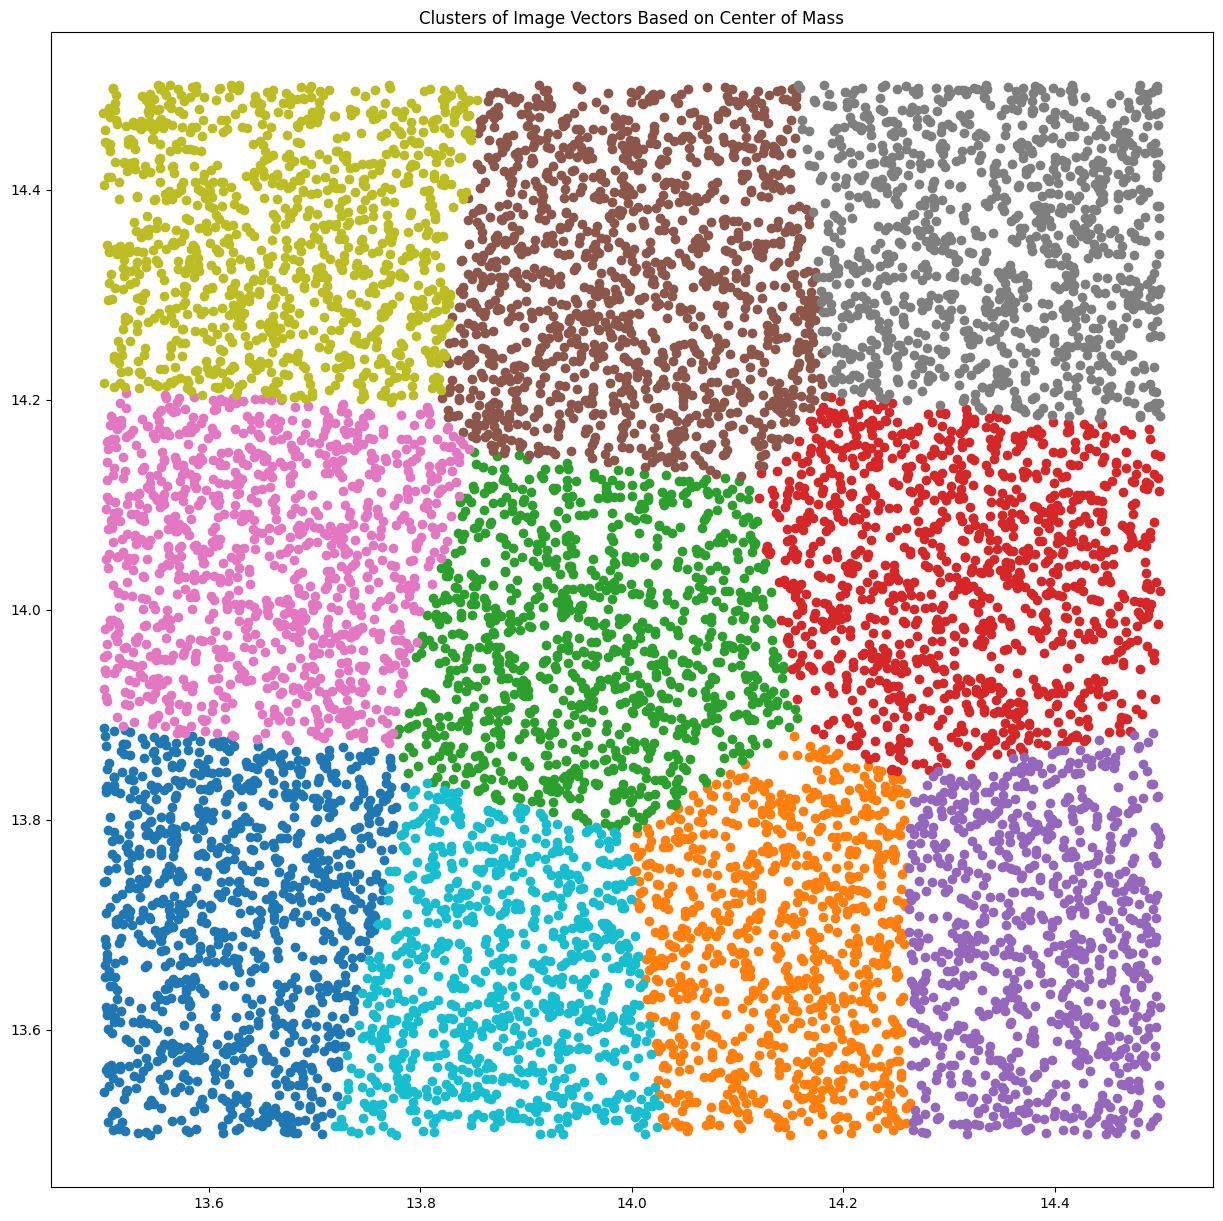

In [159]:
plt.figure(figsize=(15,15))


for i in range(10):
    xs = []
    ys = []
    for j in range(len(ComX)):
        if Xkmeans[j] == i:
            
            xs = xs + [ComX[j][0]]
            ys = ys + [ComX[j][1]]
    plt.scatter(xs, ys)

plt.title('Clusters of Image Vectors Based on Center of Mass')

In [147]:
X3 = []
for i in range(len(X)):
    X3 = X3 + [np.append(X[i], [Xkmeans[i]])]
X3 = np.array(X3)

numpy.ndarray

In [149]:
Q3, R3 = linalg.qr(X3)
U3, s3, Vh3 = linalg.svd(R3)

Text(0.5, 1.0, 'Singular Values After Adding Clustering as an Additional Dimension')

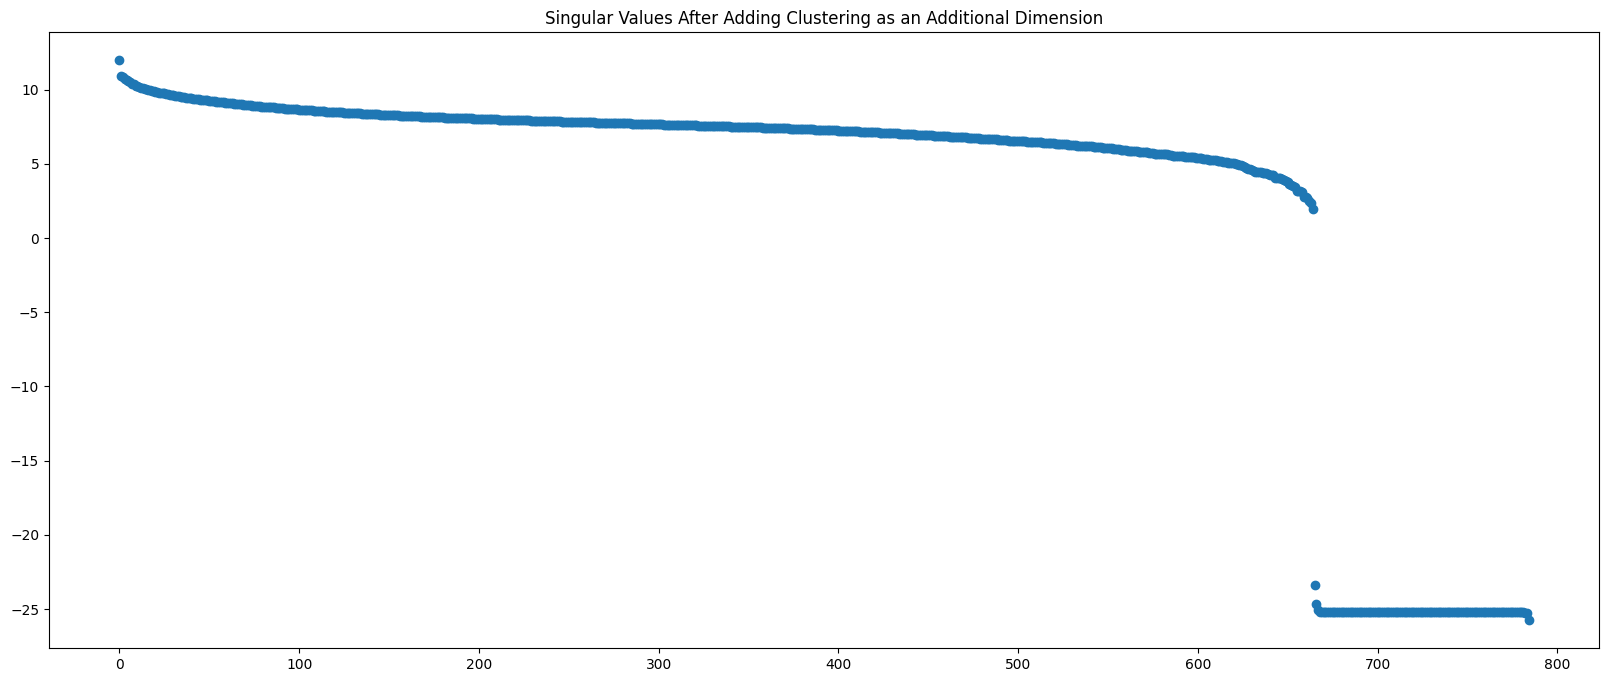

In [152]:
plt.figure(figsize=(20,8))
plt.scatter(np.arange(0,785), np.log(s3))
plt.title('Singular Values After Adding Clustering as an Additional Dimension')

In [ ]:
#So i didn't do kcluster with the features of the image as the dimensions, the runtime, even with max settings on idas, would be literally hours if not days. 